In [17]:
!git clone https://github.com/farzanhaq/CSC420.git

Cloning into 'CSC420'...
remote: Enumerating objects: 1937, done.
remote: Counting objects: 100% (1937/1937), done.
remote: Compressing objects: 100% (1901/1901), done.
remote: Total 1937 (delta 42), reused 1920 (delta 28), pack-reused 0
Receiving objects: 100% (1937/1937), 13.74 MiB | 21.65 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [0]:
# Uncomment this if you want to import data from Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump
from keras.layers import Dense
from keras.layers import Flatten

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn import datasets, svm, metrics
import cv2

mpl.rcParams['figure.dpi']=150

Given an image, filter and mode, performs pixelwise convolution on the input image. Output is the filtered version of the input image after being convoluted.

In [0]:
def convolution(I, filter, mode):
    # Store image shapes
    i_shape = I.shape
    i_rows = i_shape[0]
    i_columns = i_shape[1]

    # Store filter shapes
    h_shape = filter.shape
    h_rows = h_shape[0]
    h_columns = h_shape[1]

    # Initialize filtered image shape
    f_rows, f_columns = 0, 0

    # Determine filtered image shape based on specified mode
    if mode == 'same':
        f_rows = i_rows
        f_columns = i_columns
    elif mode == 'valid':
        f_rows = i_rows - (h_rows // 2) * 2
        f_columns = i_columns - (h_columns // 2) * 2
    elif mode == 'full':
        f_rows = i_rows + (h_rows // 2) * 2
        f_columns = i_columns + (h_columns // 2) * 2

    # Initialize filtered image with computed shape
    filtered_image = np.zeros((f_rows, f_columns))

    # Iterate through filtered images rows 
    for i in range(f_rows):
        # X coord of the pixel in the input image we center filter at currently
        image_x_pixel = i  
        # Determine correct X coord based on specified mode
        if mode == 'same':
            image_x_pixel = i
        elif mode == 'valid':
            image_x_pixel = i + (h_rows // 2)
        elif mode == 'full':
            image_x_pixel = i - (h_rows // 2)

        for j in range(f_columns):
             # Y coord of the pixel in the input image we center filter at
            image_y_pixel = j
            # Determine correct Y coord based on specified mode
            if mode == 'same':
                image_y_pixel = j
            elif mode == 'valid':
                image_y_pixel = j + (h_columns // 2)
            elif mode == 'full':
                image_y_pixel = j - (h_columns // 2)

            # Initialize sum counter
            dot_sum = 0

            # Iterate through filter row coordinates
            for k in range(-1 * (h_rows // 2), h_rows // 2 + 1):
                # Skip invalid pixels
                if image_x_pixel + k < 0 or image_x_pixel + k >= i_rows:
                    continue
                # Iterate through filter column coordinates
                for l in range(-1 * (h_columns // 2), h_columns // 2 + 1):
                    # Skip invalid pixels
                    if image_y_pixel + l < 0 or image_y_pixel + l >= i_columns:
                        continue
                    # Update sum with convolution output
                    filter_val = filter[k + h_rows // 2, l + h_columns // 2]
                    image_val = I[image_x_pixel + k, image_y_pixel + l]
                    dot_sum += filter_val * image_val

            # Update pixel in filtered image with computed sum
            filtered_image[i, j] = dot_sum

    return filtered_image

Given a path to an image of a ballot, segment the image using edge detection and return the candidate and vote

In [0]:
def segment_ballot(img_path):
    # Read image at path, convert to grayscale and perform thresholding
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    retval, img_gray_thresholded = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

    # Initialize horizontal sobel filter
    horizontal_filter = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])

    # Perform convolution on image with horizontal sobel filter
    ballot_segmentation = convolution(img_gray_thresholded, horizontal_filter, 'same')

    # Initialize lists to store coordinates of top and bottom borders
    ballot_border_top = []
    ballot_border_bottom = []

    # Iterate through ballot rows in filtered image
    for row in range(ballot_segmentation.shape[0]):
        is_border_top = True
        is_border_bottom = True
        # Iterate through ballot columns
        for col in range(ballot_segmentation.shape[1]):
            # Check if any coordinate along row does not belong to top border
            if (ballot_segmentation[row, col] >= 0):
                is_border_top = False
            # Check if any coordinate along row does not belong to bottom border
            if (ballot_segmentation[row, col] <= 0):
                is_border_bottom = False
        # Assign row oordinates of top borders
        if (is_border_top and (row-1) not in ballot_border_top):
            ballot_border_top.append(row)
        # Assign row coordinates of bottom borders
        if (is_border_bottom and (row-1) not in ballot_border_bottom):
            ballot_border_bottom.append(row)

    # Initialize list to store candidates with votes
    num_candidates_with_votes = len(ballot_border_top)
    candidate_with_vote = []

    # Iterate through number of candidates found from top and bottom border calculations
    for i in range(num_candidates_with_votes):
        # Add individual thresholded candidate and vote to list
        candidate_with_vote.append(img_gray_thresholded[ballot_border_top[i]:ballot_border_bottom[i], 0:img_gray_thresholded.shape[1]])

    # Initialize vertical sobel filter
    vertical_filter = np.array([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ])
    
    # Perform convolution on sample individual candidate with vote with vertical sobel filter
    candidate_with_vote_segmentation = convolution(candidate_with_vote[0], vertical_filter, 'same')
    ballot_border_middle = 0

    # Iterate through columns of individual candidates with votes
    for col in range(candidate_with_vote_segmentation.shape[1]):
        is_border_middle = True
        # Iterate through rows of individual candidates with votes
        for row in range(candidate_with_vote_segmentation.shape[0]):
            # Check if coordinate along column does not belong to dividing border
            if (candidate_with_vote_segmentation[row, col] <= 0):
                is_border_middle = False
        # Assign col coordinate of dividing border
        if (is_border_middle and col != 0 and (col - 1) != ballot_border_middle):
            ballot_border_middle = col

    # Initialize individual segmented candidates and votes to be returned
    candidate = []
    vote = []

    # Iterate through individual candidates with votes
    for i in range(len(candidate_with_vote)):
        # Add segmented candidate and vote to corresponding lists
        candidate.append(candidate_with_vote[i][0:candidate_with_vote[i].shape[0], 0:ballot_border_middle])
        vote.append(candidate_with_vote[i][0:candidate_with_vote[i].shape[0], ballot_border_middle:candidate_with_vote[i].shape[1]])

    return candidate, vote

Given the path to a directory of images, the number of images in that directory and appropriate prefix, read the images and augment them with flips, noise and blur

In [0]:
def augment_data(dir_path, num_images, prefix):
    # Iterate through images in folder
    for j in range(num_images):
        image_path = '{}/{}_votes/{}_vote_{}.png'.format(dir_path, prefix, prefix, j)
        img = cv2.imread(image_path, 0)
        
        # Augment the image by flipping it
        img_flip = cv2.flip(img, 1)

        # Augment the image by adding noise
        img_noise = img + 2 * img.std() * np.random.random(img.shape)

        # Initialize gaussian filter
        gaussian_filter = np.array([
            [1/16, 1/8, 1/16],
            [1/8, 1/4, 1/8],
            [1/16, 1/8, 1/16]
        ])

        # Augment the image by manually performing a gaussian blur
        img_blur = convolution(img, gaussian_filter, 'same')

        # Create unique output paths to save images
        output_flip_path = '{}/{}_votes/{}_vote_flip_{}.png'.format(dir_path, prefix, prefix, j)
        output_noise_path = '{}/{}_votes/{}_vote_noise_{}.png'.format(dir_path, prefix, prefix, j)
        output_blur_path = '{}/{}_votes/{}_vote_blur_{}.png'.format(dir_path, prefix, prefix, j)

        cv2.imwrite(output_flip_path, img_flip)
        cv2.imwrite(output_noise_path, img_noise)
        cv2.imwrite(output_blur_path, img_blur)

Given the path to a directory of images, the number of images in that directory and appropriate prefix, read the images and extract the votes for the dataset

In [0]:
def extract_marks(dir_path, num_images, prefix):
    # Iterate through images in folder
    for j in range(num_images):
        image_path = '{}/{}/{}_{}.png'.format(dir_path, prefix, prefix, j)

        # Segment the image
        candidate, vote = segment_ballot(image_path)

        # Create unique output path
        output_path = '{}/{}_votes/{}_vote_{}.png'.format(dir_path, prefix, prefix, j)

        # Save the first vote
        cv2.imwrite(output_path, vote[0])

This block of code extracts the candidates name from the given image of a row

In [0]:
def convertFromBGRToGray(image):
    # Convert given image to greyscale
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return gray

def loadTemplates(names, dirPath):
    # Load the templates from disk
    templates = {}
    for name in names:
        template_image = cv2.imread(dirPath + '{}.png'.format(name))
        templates[name] = convertFromBGRToGray(template_image)
    
    return templates

def templateMatching(image, template):
    # The template matching function. It slides over the given image
    # and calculates normalized cross_correlation at each point, returning the 
    # highest score it calculates
    end_row = image.shape[0] - template.shape[0] + 1
    end_col = image.shape[1] - template.shape[1] + 1
    
    temp_rows = template.shape[0]
    temp_cols = template.shape[1]
    
    max_val = float("-inf")
    
    for i in range(end_row):
        for j in range(end_col):
            I = image[i:i + temp_rows, j: j + temp_cols]

            score = np.dot(template.flatten().T, I.flatten().T)

            i_bar = math.sqrt(np.sum(np.square(I)))
            t_bar = math.sqrt(np.sum(np.square(template)))
            normalised_factor = i_bar * t_bar

            norm_score = score / normalised_factor
            if norm_score > max_val:
                max_val = norm_score
            
    return max_val

def get_candidate_name(img):
    # This function iterates through the templates and calls the template 
    # matching function. The template which returns the highest score has the
    # name of the candidate which matches the one in the image.
    initials_to_names = {
        'as': 'Andrew Scheer',
        'em': 'Elizabeth May',
        'js': 'Jagmeet Singh',
        'jt': 'Justin Trudeau',
        'mb': 'Maxime Bernier',
        'yb': 'Yves-François Blanchet'
    }
    
    image = img.copy()
    
    template_names = ['as', 'em', 'js', 'jt', 'mb', 'yb']
    
    templates = loadTemplates(template_names, 'CSC420/templates/')
    max_score = 0
    max_contendor = None
    
    for key in templates:
        template = templates[key]

        res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        # max_val = templateMatching(image, template)
    
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        if max_val > max_score:
            max_score = max_val
            max_contendor = key
    
    return max_contendor

These are our two networks. The first CNN() is a simple network that builds on the VGG16 network. It just takes the features extracted by VGG16, applies a classifcation layer and then a sigmoid to classify it as a binary output

The VGG16 network is a pretrained netowrk. We take out its final classification layer and instead just use it for extracting features from our images.

In [0]:
def CNN():
    # Our own network. Take the features received from the VGG16 network and
    # apply a dense layer as our classification layer followed by a sigmoid
    # to bring our prediction down to a value between 0 and 1
    model = models.Sequential()

    model.add(layers.Dense(1024, activation='relu', input_shape=(4096,)))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

def get_transfer_model():
	# Load the model for transfer learning
	model = VGG16()
	# Remove its last classification learning
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

	return model

In [0]:
def get_models():
    # Load the dataset, train our model using the VGG16 as a feature extractor
    x, y = load_dataset()
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15)
    
    transfer_model = get_transfer_model()
    
    train_features = transfer_model.predict(train_x)
    test_features = transfer_model.predict(test_x)
    
    my_model = CNN()
    # Used binary cross entropy as it works best for this case of a network
    # where our output is a binary classifier
    my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    my_model.fit(train_features, np.array(train_y), batch_size=10, epochs=25, validation_data=(test_features, np.array(test_y)))    
    
    return transfer_model, my_model	

In [0]:
def load_dataset():
    # Preprocess the images and prepare them for the network
    print("Loading dataset")
    root_dir = 'CSC420/dataset'
    valid_dir = '{}/valid_votes'.format(root_dir)
    invalid_dir = '{}/invalid_votes'.format(root_dir)

    valid_files = os.listdir(valid_dir)
    invalid_files = os.listdir(invalid_dir)

    train_x = []
    train_y = []

    for f in valid_files:
        filename = '{}/{}'.format(valid_dir, f)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        train_x.append(image)
        train_y.append(1)
        
    for f in invalid_files:
        filename = '{}/{}'.format(invalid_dir, f)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        train_x.append(image)
        train_y.append(0)
    
    train_x = np.array(train_x)
    print("Dataset finished loading")

    return train_x, train_y

In [0]:
def get_cast_ballots():
    # Get the simulation ballots from disk, segment them into sections
    ballot_dir = 'CSC420/simulation'
    ballot_files = os.listdir(ballot_dir)

    ballots = []

    for i in range(len(ballot_files)):
        filename = '{}/{}'.format(ballot_dir, ballot_files[i])
        candidate, votes = segment_ballot(filename)
        ballots.append((candidate, votes))
    return ballots

def get_ballot_result(transfer_model, my_model, candidates, votes):
    # Take each ballot and determine if it is valid or invalid
    cand_array = []
    vote_array = []
    valid_ballot = 0

    # For each row, extract the candidate name and determine if the mark against
    # it is valid or invalid
    for i in range(len(candidates)):
        candidate = get_candidate_name(candidates[i])
        print("Candidate is {}".format(candidate))
        cand_array.append(candidate)
        vote = votes[i]
        cv2.imwrite('temp.png', vote)
        image = load_img('temp.png', target_size=(224, 224))
        os.remove('temp.png')
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image_features = transfer_model.predict(image)
        model_input = np.array(image_features)
        prediction = my_model.predict(model_input)
        print("Prediction {}: {}".format(i, prediction))
        if prediction > 0.75:
            vote_array.append(1)
            valid_ballot += 1
        else:
            vote_array.append(0)

    print(vote_array)

    # Tally all the votes and determine if the whole ballot is valid or not 
    if valid_ballot == 0 or valid_ballot > 1:
        print("Invalid Ballot")
        return False, None

    print("Ballot is valid")
    cand_win = cand_array[np.argmax(np.array(vote_array))]
    print("Ballot won by {}".format(cand_win))
    return True, cand_win

def evaluate_election():
    # Determine the result of the election simulated by the simulation ballots
    initials_to_names = {
        'as': 'Andrew Scheer',
        'em': 'Elizabeth May',
        'js': 'Jagmeet Singh',
        'jt': 'Justin Trudeau',
        'mb': 'Maxime Bernier',
        'yb': 'Yves-François Blanchet'
    }

    votes_count = {
        'as': 0,
        'em': 0,
        'js': 0,
        'jt': 0,
        'mb': 0,
        'yb': 0
    }

    transfer_model, my_model = get_models()

    cast_ballots = get_cast_ballots()
    for ballot in cast_ballots:
        candidate, vote = ballot
        result, winner = get_ballot_result(transfer_model, my_model, candidate, vote)
        if result is True:
            print(winner)
            votes_count[winner] = votes_count[winner] + 1
        print("")
    
    cand_array = []
    votes_array = []
    print("")

    for key in votes_count.keys():
        cand_array.append(key)
        c = initials_to_names[key]
        v = votes_count[key]
        votes_array.append(v)

        print('{} received {} votes'.format(c, v))

    winner = cand_array[np.argmax(np.array(votes_array))]
    print("")
    print("The winner is {}".format(initials_to_names[winner]))

The next few outputs show the images that the simulation is run on.

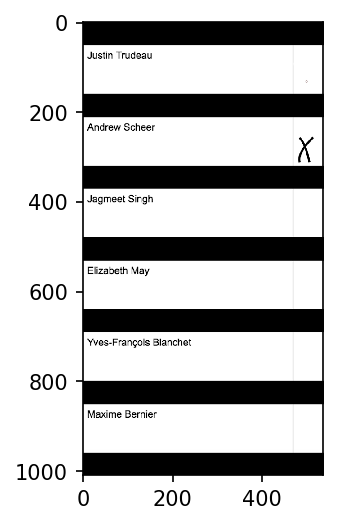

In [35]:
plt.imshow(cv2.imread('CSC420/simulation/vote_0.png'))

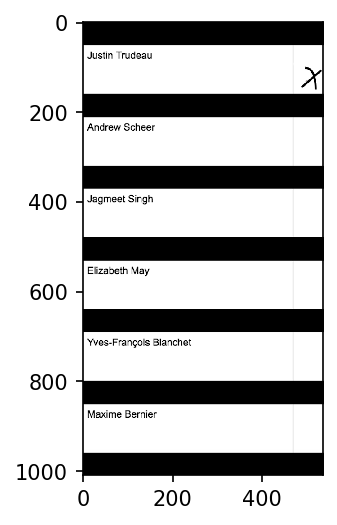

In [36]:
plt.imshow(cv2.imread('CSC420/simulation/vote_1.png'))

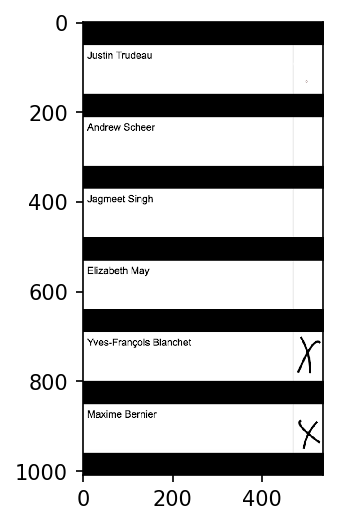

In [37]:
plt.imshow(cv2.imread('CSC420/simulation/vote_2.png'))

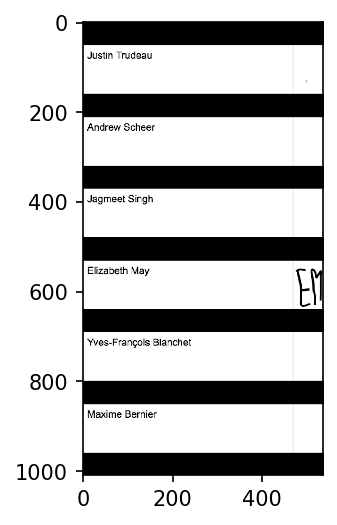

In [38]:
plt.imshow(cv2.imread('CSC420/simulation/vote_3.png'))

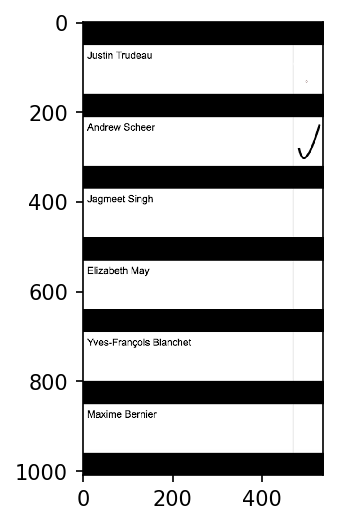

In [39]:
plt.imshow(cv2.imread('CSC420/simulation/vote_4.png'))

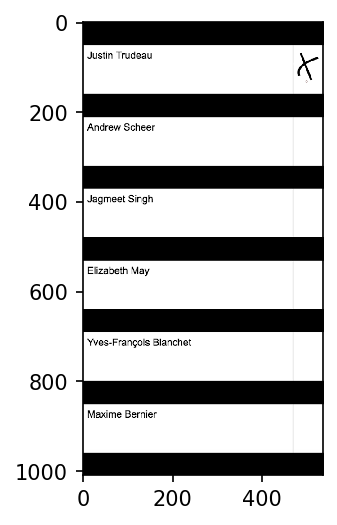

In [40]:
plt.imshow(cv2.imread('CSC420/simulation/vote_5.png'))

The main function, this will run the call to evaluate the election

In [41]:
evaluate_election()

Loading dataset
Dataset finished loading
Train on 680 samples, validate on 120 samples
Epoch 1/25
680/680 [==============================] - 0s 582us/sample - loss: 1.3366 - acc: 0.8118 - val_loss: 0.1965 - val_acc: 0.9167
Epoch 2/25
680/680 [==============================] - 0s 332us/sample - loss: 0.1681 - acc: 0.9368 - val_loss: 0.1483 - val_acc: 0.9417
Epoch 3/25
680/680 [==============================] - 0s 341us/sample - loss: 0.1375 - acc: 0.9338 - val_loss: 0.2132 - val_acc: 0.9250
Epoch 4/25
680/680 [==============================] - 0s 337us/sample - loss: 0.0980 - acc: 0.9574 - val_loss: 0.1007 - val_acc: 0.9500
Epoch 5/25
680/680 [==============================] - 0s 339us/sample - loss: 0.0570 - acc: 0.9838 - val_loss: 0.1066 - val_acc: 0.9667
Epoch 6/25
680/680 [==============================] - 0s 325us/sample - loss: 0.0249 - acc: 0.9971 - val_loss: 0.1061 - val_acc: 0.9500
Epoch 7/25
680/680 [==============================] - 0s 335us/sample - loss: 0.0310 - acc: 0.991